In [1]:
# Import required libraries
%pip install optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna
import random

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downgrade numpy for TensorFlow compatibility (run this cell and restart kernel)
%pip install numpy==1.26.4


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load dataset and select top 14 features
features = [
    'RiskScore', 'MonthlyCharges', 'AvgChargesPerMonth', 'ContractRisk', 'Contract',
    'TotalServices', 'TotalCharges', 'EstimatedCLV', 'HasFamily', 'tenure',
    'Partner', 'HighValueCustomer', 'PaymentRisk', 'Dependents'
]
df = pd.read_csv('final_telco_engineered.csv')
X = df[features]
# Assuming target column is 'Churn' (update if different)
y = df['Churn']

In [4]:
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['Contract', 'HasFamily', 'Partner', 'HighValueCustomer', 'Dependents']
numerical_cols = [col for col in features if col not in categorical_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [5]:
# Train/validation/test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)
# 0.1111 * 0.90 ≈ 0.10

In [6]:
# Ensure target variable is numeric (0/1)
if y_train.dtype == 'O' or y_train.dtype.name == 'category':
    y_train = y_train.map({'No': 0, 'Yes': 1}).astype(int)
    y_val = y_val.map({'No': 0, 'Yes': 1}).astype(int)
    y_test = y_test.map({'No': 0, 'Yes': 1}).astype(int)

In [7]:
# Fit preprocessor on ORIGINAL training data (before oversampling)
# This ensures scaling parameters reflect true feature distribution
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Now apply random oversampling to balance classes 50/50 on PREPROCESSED training data
from sklearn.utils import resample

# Show class distribution before oversampling
print("Before oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))

# Combine preprocessed X_train and y_train for resampling
_df_train = pd.DataFrame(X_train_proc)
_df_train['Churn'] = y_train.reset_index(drop=True)
_df_majority = _df_train[_df_train['Churn'] == 0]
_df_minority = _df_train[_df_train['Churn'] == 1]

# Upsample minority to match majority count
_df_minority_up = resample(
    _df_minority,
    replace=True,
    n_samples=len(_df_majority),
    random_state=SEED,
)

# Recombine and shuffle
_df_balanced = pd.concat([_df_majority, _df_minority_up], axis=0)
_df_balanced = _df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Split back into features/target
X_train_proc = _df_balanced.drop(columns=['Churn']).values
y_train = _df_balanced['Churn'].astype(int).values

print("\nAfter oversampling:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts(normalize=True))


Before oversampling:
Churn
0    4138
1    1495
Name: count, dtype: int64
Churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64

After oversampling:
0    4138
1    4138
Name: count, dtype: int64
0    0.5
1    0.5
Name: proportion, dtype: float64



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[I 2025-11-21 17:29:41,407] A new study created in memory with name: no-name-f473964d-5171-4f19-bfdb-d04d7b4c719b
Best trial: 0. Best value: 0.648:   2%|▏         | 1/50 [00:19<15:48, 19.37s/it]

Early stopping at epoch 12; best val F1=0.6480
Trial early stopped at epoch 12 (best val F1=0.6480)
[I 2025-11-21 17:30:00,773] Trial 0 finished with value: 0.648 and parameters: {'n_units': 58, 'lr': 0.007969454818643935, 'dropout': 0.36599697090570255, 'batch_size': 90}. Best is trial 0 with value: 0.648.


Best trial: 0. Best value: 0.648:   4%|▍         | 2/50 [00:48<19:51, 24.82s/it]

Early stopping at epoch 18; best val F1=0.6474
Trial early stopped at epoch 18 (best val F1=0.6474)
[I 2025-11-21 17:30:29,414] Trial 1 finished with value: 0.6474226804123712 and parameters: {'n_units': 33, 'lr': 0.00020511104188433984, 'dropout': 0.02904180608409973, 'batch_size': 116}. Best is trial 0 with value: 0.648.


Best trial: 2. Best value: 0.652977:   6%|▌         | 3/50 [01:24<23:39, 30.20s/it]

[I 2025-11-21 17:31:06,010] Trial 2 finished with value: 0.6529774127310062 and parameters: {'n_units': 83, 'lr': 0.0026070247583707684, 'dropout': 0.010292247147901223, 'batch_size': 126}. Best is trial 2 with value: 0.6529774127310062.


Best trial: 2. Best value: 0.652977:   8%|▊         | 4/50 [01:51<22:04, 28.80s/it]

Early stopping at epoch 9; best val F1=0.6390
Trial early stopped at epoch 9 (best val F1=0.6390)
[I 2025-11-21 17:31:32,677] Trial 3 finished with value: 0.6390041493775933 and parameters: {'n_units': 110, 'lr': 0.00026587543983272726, 'dropout': 0.09091248360355031, 'batch_size': 49}. Best is trial 2 with value: 0.6529774127310062.


Best trial: 2. Best value: 0.652977:  10%|█         | 5/50 [02:13<19:47, 26.40s/it]

Early stopping at epoch 8; best val F1=0.6347
Trial early stopped at epoch 8 (best val F1=0.6347)
[I 2025-11-21 17:31:54,807] Trial 4 finished with value: 0.6346555323590815 and parameters: {'n_units': 50, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 2 with value: 0.6529774127310062.


Best trial: 5. Best value: 0.654244:  12%|█▏        | 6/50 [03:02<25:06, 34.23s/it]

Early stopping at epoch 24; best val F1=0.6542
Trial early stopped at epoch 24 (best val F1=0.6542)
[I 2025-11-21 17:32:44,240] Trial 5 finished with value: 0.6542443064182195 and parameters: {'n_units': 85, 'lr': 0.00019010245319870352, 'dropout': 0.14607232426760908, 'batch_size': 67}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  14%|█▍        | 7/50 [03:26<21:59, 30.70s/it]

Early stopping at epoch 11; best val F1=0.6490
Trial early stopped at epoch 11 (best val F1=0.6490)
[I 2025-11-21 17:33:07,662] Trial 6 finished with value: 0.6489795918367347 and parameters: {'n_units': 67, 'lr': 0.0037183641805732083, 'dropout': 0.09983689107917987, 'batch_size': 81}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  16%|█▌        | 8/50 [04:25<27:52, 39.82s/it]

Early stopping at epoch 21; best val F1=0.6379
Trial early stopped at epoch 21 (best val F1=0.6379)
[I 2025-11-21 17:34:07,034] Trial 7 finished with value: 0.6378600823045267 and parameters: {'n_units': 82, 'lr': 0.0001238513729886094, 'dropout': 0.3037724259507192, 'batch_size': 48}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  18%|█▊        | 9/50 [04:47<23:26, 34.31s/it]

Early stopping at epoch 14; best val F1=0.6316
Trial early stopped at epoch 14 (best val F1=0.6316)
[I 2025-11-21 17:34:29,225] Trial 8 finished with value: 0.631578947368421 and parameters: {'n_units': 23, 'lr': 0.007902619549708232, 'dropout': 0.4828160165372797, 'batch_size': 110}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  20%|██        | 10/50 [05:39<26:32, 39.81s/it]

Early stopping at epoch 26; best val F1=0.6433
Trial early stopped at epoch 26 (best val F1=0.6433)
[I 2025-11-21 17:35:21,329] Trial 9 finished with value: 0.643298969072165 and parameters: {'n_units': 50, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  22%|██▏       | 11/50 [06:42<30:20, 46.67s/it]

Early stopping at epoch 15; best val F1=0.6364
Trial early stopped at epoch 15 (best val F1=0.6364)
[I 2025-11-21 17:36:23,559] Trial 10 finished with value: 0.6363636363636364 and parameters: {'n_units': 124, 'lr': 0.0005338943774556114, 'dropout': 0.18626884362117777, 'batch_size': 33}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  24%|██▍       | 12/50 [06:54<22:56, 36.22s/it]

Early stopping at epoch 8; best val F1=0.6331
Trial early stopped at epoch 8 (best val F1=0.6331)
[I 2025-11-21 17:36:35,887] Trial 11 finished with value: 0.6331236897274634 and parameters: {'n_units': 90, 'lr': 0.0015084240403991644, 'dropout': 0.0045815577638079995, 'batch_size': 126}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  26%|██▌       | 13/50 [07:12<18:54, 30.67s/it]

Early stopping at epoch 9; best val F1=0.6303
Trial early stopped at epoch 9 (best val F1=0.6303)
[I 2025-11-21 17:36:53,797] Trial 12 finished with value: 0.6303030303030303 and parameters: {'n_units': 95, 'lr': 0.002710416521357971, 'dropout': 0.14038047711985213, 'batch_size': 99}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  28%|██▊       | 14/50 [07:39<17:48, 29.68s/it]

Early stopping at epoch 11; best val F1=0.6393
Trial early stopped at epoch 11 (best val F1=0.6393)
[I 2025-11-21 17:37:21,191] Trial 13 finished with value: 0.639344262295082 and parameters: {'n_units': 103, 'lr': 0.0004903123807866562, 'dropout': 0.06434142014906205, 'batch_size': 71}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  30%|███       | 15/50 [08:11<17:43, 30.38s/it]

Early stopping at epoch 19; best val F1=0.6309
Trial early stopped at epoch 19 (best val F1=0.6309)
[I 2025-11-21 17:37:53,191] Trial 14 finished with value: 0.6309278350515464 and parameters: {'n_units': 78, 'lr': 0.0021002043626702762, 'dropout': 0.15256035042338484, 'batch_size': 95}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  32%|███▏      | 16/50 [08:43<17:22, 30.65s/it]

Early stopping at epoch 12; best val F1=0.6405
Trial early stopped at epoch 12 (best val F1=0.6405)
[I 2025-11-21 17:38:24,452] Trial 15 finished with value: 0.640495867768595 and parameters: {'n_units': 119, 'lr': 0.0004913460742665332, 'dropout': 0.2646549837893469, 'batch_size': 58}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  34%|███▍      | 17/50 [09:11<16:33, 30.10s/it]

Early stopping at epoch 20; best val F1=0.6471
Trial early stopped at epoch 20 (best val F1=0.6471)
[I 2025-11-21 17:38:53,278] Trial 16 finished with value: 0.6470588235294118 and parameters: {'n_units': 71, 'lr': 0.0008488539352123737, 'dropout': 0.004970079125886734, 'batch_size': 128}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  36%|███▌      | 18/50 [09:30<14:17, 26.78s/it]

Early stopping at epoch 11; best val F1=0.6316
Trial early stopped at epoch 11 (best val F1=0.6316)
[I 2025-11-21 17:39:12,342] Trial 17 finished with value: 0.631578947368421 and parameters: {'n_units': 89, 'lr': 0.003703268825853674, 'dropout': 0.13042253680072105, 'batch_size': 108}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  38%|███▊      | 19/50 [09:52<13:00, 25.17s/it]

Early stopping at epoch 10; best val F1=0.6387
Trial early stopped at epoch 10 (best val F1=0.6387)
[I 2025-11-21 17:39:33,761] Trial 18 finished with value: 0.6386554621848739 and parameters: {'n_units': 108, 'lr': 0.0003041654393076622, 'dropout': 0.05581398126150831, 'batch_size': 87}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  40%|████      | 20/50 [10:54<18:07, 36.26s/it]

[I 2025-11-21 17:40:35,875] Trial 19 finished with value: 0.6503067484662577 and parameters: {'n_units': 64, 'lr': 0.00010617417099250874, 'dropout': 0.2179190079240281, 'batch_size': 66}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  42%|████▏     | 21/50 [11:36<18:26, 38.14s/it]

Early stopping at epoch 11; best val F1=0.6503
Trial early stopped at epoch 11 (best val F1=0.6503)
[I 2025-11-21 17:41:18,401] Trial 20 finished with value: 0.6503067484662577 and parameters: {'n_units': 98, 'lr': 0.004200619720574957, 'dropout': 0.4264342202471388, 'batch_size': 48}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  44%|████▍     | 22/50 [12:51<22:57, 49.18s/it]

Early stopping at epoch 30; best val F1=0.6405
Trial early stopped at epoch 30 (best val F1=0.6405)
[I 2025-11-21 17:42:33,322] Trial 21 finished with value: 0.640495867768595 and parameters: {'n_units': 62, 'lr': 0.00010523954769406688, 'dropout': 0.22474528734773241, 'batch_size': 66}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  46%|████▌     | 23/50 [13:50<23:23, 51.97s/it]

[I 2025-11-21 17:43:31,810] Trial 22 finished with value: 0.6515463917525773 and parameters: {'n_units': 78, 'lr': 0.00017621185816747625, 'dropout': 0.18545506763383135, 'batch_size': 79}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  48%|████▊     | 24/50 [14:10<18:18, 42.27s/it]

Early stopping at epoch 7; best val F1=0.6320
Trial early stopped at epoch 7 (best val F1=0.6320)
[I 2025-11-21 17:43:51,431] Trial 23 finished with value: 0.632016632016632 and parameters: {'n_units': 84, 'lr': 0.0003062716376037914, 'dropout': 0.2678401811860963, 'batch_size': 82}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  50%|█████     | 25/50 [14:34<15:21, 36.85s/it]

Early stopping at epoch 10; best val F1=0.6362
Trial early stopped at epoch 10 (best val F1=0.6362)
[I 2025-11-21 17:44:15,636] Trial 24 finished with value: 0.6361746361746362 and parameters: {'n_units': 76, 'lr': 0.000785974728314471, 'dropout': 0.1720120201414774, 'batch_size': 103}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  52%|█████▏    | 26/50 [14:58<13:17, 33.22s/it]

Early stopping at epoch 11; best val F1=0.6405
Trial early stopped at epoch 11 (best val F1=0.6405)
[I 2025-11-21 17:44:40,404] Trial 25 finished with value: 0.640495867768595 and parameters: {'n_units': 51, 'lr': 0.00018522882375907084, 'dropout': 0.10650646210576738, 'batch_size': 78}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  54%|█████▍    | 27/50 [15:28<12:19, 32.17s/it]

Early stopping at epoch 17; best val F1=0.6283
Trial early stopped at epoch 17 (best val F1=0.6283)
[I 2025-11-21 17:45:10,117] Trial 26 finished with value: 0.6283367556468172 and parameters: {'n_units': 90, 'lr': 0.0017516370334289138, 'dropout': 0.062124300582986375, 'batch_size': 89}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  56%|█████▌    | 28/50 [16:34<15:27, 42.15s/it]

Early stopping at epoch 21; best val F1=0.6430
Trial early stopped at epoch 21 (best val F1=0.6430)
[I 2025-11-21 17:46:15,570] Trial 27 finished with value: 0.6430062630480167 and parameters: {'n_units': 74, 'lr': 0.0003603086451237453, 'dropout': 0.18655602569220736, 'batch_size': 60}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  58%|█████▊    | 29/50 [17:02<13:16, 37.91s/it]

Early stopping at epoch 17; best val F1=0.6349
Trial early stopped at epoch 17 (best val F1=0.6349)
[I 2025-11-21 17:46:43,575] Trial 28 finished with value: 0.6348547717842323 and parameters: {'n_units': 39, 'lr': 0.005746371374539819, 'dropout': 0.3026856510100312, 'batch_size': 119}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  60%|██████    | 30/50 [17:39<12:34, 37.74s/it]

Early stopping at epoch 9; best val F1=0.6380
Trial early stopped at epoch 9 (best val F1=0.6380)
[I 2025-11-21 17:47:20,914] Trial 29 finished with value: 0.6380368098159509 and parameters: {'n_units': 113, 'lr': 0.0012725963982280844, 'dropout': 0.3627714831811072, 'batch_size': 40}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  62%|██████▏   | 31/50 [18:22<12:27, 39.33s/it]

Early stopping at epoch 22; best val F1=0.6472
Trial early stopped at epoch 22 (best val F1=0.6472)
[I 2025-11-21 17:48:03,950] Trial 30 finished with value: 0.6471816283924844 and parameters: {'n_units': 57, 'lr': 0.0006584917039848024, 'dropout': 0.11589827494643759, 'batch_size': 70}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  64%|██████▍   | 32/50 [18:53<11:00, 36.71s/it]

Early stopping at epoch 12; best val F1=0.6367
Trial early stopped at epoch 12 (best val F1=0.6367)
[I 2025-11-21 17:48:34,540] Trial 31 finished with value: 0.636734693877551 and parameters: {'n_units': 64, 'lr': 0.00014070491491018593, 'dropout': 0.2136095719200475, 'batch_size': 67}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  66%|██████▌   | 33/50 [19:29<10:19, 36.46s/it]

Early stopping at epoch 12; best val F1=0.6403
Trial early stopped at epoch 12 (best val F1=0.6403)
[I 2025-11-21 17:49:10,434] Trial 32 finished with value: 0.6403326403326404 and parameters: {'n_units': 83, 'lr': 0.00019915955562044903, 'dropout': 0.23680159248441685, 'batch_size': 77}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  68%|██████▊   | 34/50 [20:47<13:04, 49.02s/it]

[I 2025-11-21 17:50:28,766] Trial 33 finished with value: 0.6419753086419753 and parameters: {'n_units': 71, 'lr': 0.00010066452938678328, 'dropout': 0.2918220159552396, 'batch_size': 54}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  70%|███████   | 35/50 [21:24<11:20, 45.38s/it]

Early stopping at epoch 15; best val F1=0.6486
Trial early stopped at epoch 15 (best val F1=0.6486)
[I 2025-11-21 17:51:05,635] Trial 34 finished with value: 0.6486486486486487 and parameters: {'n_units': 56, 'lr': 0.00022775680896702723, 'dropout': 0.17307108364432147, 'batch_size': 64}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  72%|███████▏  | 36/50 [22:18<11:12, 48.06s/it]

[I 2025-11-21 17:51:59,956] Trial 35 finished with value: 0.6460905349794238 and parameters: {'n_units': 98, 'lr': 0.00013984114337333095, 'dropout': 0.20685125319960396, 'batch_size': 83}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  74%|███████▍  | 37/50 [22:51<09:27, 43.62s/it]

Early stopping at epoch 17; best val F1=0.6430
Trial early stopped at epoch 17 (best val F1=0.6430)
[I 2025-11-21 17:52:33,222] Trial 36 finished with value: 0.6430062630480167 and parameters: {'n_units': 68, 'lr': 0.00037845882809747934, 'dropout': 0.08381803268021887, 'batch_size': 94}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  76%|███████▌  | 38/50 [24:03<10:24, 52.02s/it]

[I 2025-11-21 17:53:44,824] Trial 37 finished with value: 0.6348547717842323 and parameters: {'n_units': 37, 'lr': 0.000174440041847256, 'dropout': 0.24975637008184293, 'batch_size': 55}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  78%|███████▊  | 39/50 [24:48<09:08, 49.91s/it]

Early stopping at epoch 23; best val F1=0.6475
Trial early stopped at epoch 23 (best val F1=0.6475)
[I 2025-11-21 17:54:29,817] Trial 38 finished with value: 0.6475409836065574 and parameters: {'n_units': 80, 'lr': 0.00011371613727588107, 'dropout': 0.14916447134225255, 'batch_size': 72}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  80%|████████  | 40/50 [25:12<07:00, 42.09s/it]

Early stopping at epoch 12; best val F1=0.6474
Trial early stopped at epoch 12 (best val F1=0.6474)
[I 2025-11-21 17:54:53,657] Trial 39 finished with value: 0.6474226804123712 and parameters: {'n_units': 86, 'lr': 0.00024567274930563414, 'dropout': 0.04549179641584673, 'batch_size': 86}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  82%|████████▏ | 41/50 [25:37<05:32, 36.92s/it]

Early stopping at epoch 6; best val F1=0.6424
Trial early stopped at epoch 6 (best val F1=0.6424)
[I 2025-11-21 17:55:18,516] Trial 40 finished with value: 0.6423982869379015 and parameters: {'n_units': 63, 'lr': 0.008142159677433498, 'dropout': 0.33324161041254263, 'batch_size': 41}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  84%|████████▍ | 42/50 [26:07<04:40, 35.07s/it]

Early stopping at epoch 9; best val F1=0.6463
Trial early stopped at epoch 9 (best val F1=0.6463)
[I 2025-11-21 17:55:49,266] Trial 41 finished with value: 0.6463414634146342 and parameters: {'n_units': 100, 'lr': 0.005441253606737158, 'dropout': 0.2034211972617312, 'batch_size': 49}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  86%|████████▌ | 43/50 [26:33<03:45, 32.27s/it]

Early stopping at epoch 6; best val F1=0.6387
Trial early stopped at epoch 6 (best val F1=0.6387)
[I 2025-11-21 17:56:15,013] Trial 42 finished with value: 0.6387225548902196 and parameters: {'n_units': 109, 'lr': 0.0025146444860712847, 'dropout': 0.4479136953384979, 'batch_size': 63}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 5. Best value: 0.654244:  88%|████████▊ | 44/50 [27:07<03:16, 32.81s/it]

Early stopping at epoch 6; best val F1=0.6515
Trial early stopped at epoch 6 (best val F1=0.6515)
[I 2025-11-21 17:56:49,087] Trial 43 finished with value: 0.6514522821576764 and parameters: {'n_units': 93, 'lr': 0.003338397749029435, 'dropout': 0.4303623935426553, 'batch_size': 37}. Best is trial 5 with value: 0.6542443064182195.


Best trial: 44. Best value: 0.657025:  90%|█████████ | 45/50 [28:15<03:36, 43.32s/it]

Early stopping at epoch 15; best val F1=0.6570
Trial early stopped at epoch 15 (best val F1=0.6570)
[I 2025-11-21 17:57:56,910] Trial 44 finished with value: 0.6570247933884298 and parameters: {'n_units': 93, 'lr': 0.0032181723216099974, 'dropout': 0.40705364339981426, 'batch_size': 35}. Best is trial 44 with value: 0.6570247933884298.


Best trial: 44. Best value: 0.657025:  92%|█████████▏| 46/50 [29:14<03:11, 47.98s/it]

Early stopping at epoch 11; best val F1=0.6475
Trial early stopped at epoch 11 (best val F1=0.6475)
[I 2025-11-21 17:58:55,782] Trial 45 finished with value: 0.6475409836065574 and parameters: {'n_units': 92, 'lr': 0.0029970153402072057, 'dropout': 0.43474676077364915, 'batch_size': 32}. Best is trial 44 with value: 0.6570247933884298.


Best trial: 44. Best value: 0.657025:  94%|█████████▍| 47/50 [30:01<02:23, 47.75s/it]

Early stopping at epoch 6; best val F1=0.6441
Trial early stopped at epoch 6 (best val F1=0.6441)
[I 2025-11-21 17:59:42,989] Trial 46 finished with value: 0.6440677966101694 and parameters: {'n_units': 105, 'lr': 0.005839923347160845, 'dropout': 0.48526591162658494, 'batch_size': 39}. Best is trial 44 with value: 0.6570247933884298.


Best trial: 44. Best value: 0.657025:  96%|█████████▌| 48/50 [30:38<01:28, 44.49s/it]

Early stopping at epoch 8; best val F1=0.6478
Trial early stopped at epoch 8 (best val F1=0.6478)
[I 2025-11-21 18:00:19,883] Trial 47 finished with value: 0.6477732793522267 and parameters: {'n_units': 95, 'lr': 0.0020197546233396277, 'dropout': 0.40523843096324347, 'batch_size': 43}. Best is trial 44 with value: 0.6570247933884298.


Best trial: 44. Best value: 0.657025:  98%|█████████▊| 49/50 [31:26<00:45, 45.54s/it]

Early stopping at epoch 9; best val F1=0.6501
Trial early stopped at epoch 9 (best val F1=0.6501)
[I 2025-11-21 18:01:07,869] Trial 48 finished with value: 0.650103519668737 and parameters: {'n_units': 79, 'lr': 0.004208404990906128, 'dropout': 0.36380059646820906, 'batch_size': 36}. Best is trial 44 with value: 0.6570247933884298.


Best trial: 44. Best value: 0.657025: 100%|██████████| 50/50 [31:53<00:00, 38.27s/it]

Early stopping at epoch 8; best val F1=0.6427
Trial early stopped at epoch 8 (best val F1=0.6427)
[I 2025-11-21 18:01:34,844] Trial 49 finished with value: 0.642706131078224 and parameters: {'n_units': 87, 'lr': 0.001297506133145189, 'dropout': 0.38894368853066735, 'batch_size': 121}. Best is trial 44 with value: 0.6570247933884298.
Best FNN hyperparameters: {'n_units': 93, 'lr': 0.0032181723216099974, 'dropout': 0.40705364339981426, 'batch_size': 35}


Early stopping at epoch 10; best val F1=0.6503
Final FNN early stopped at epoch 10 (best val F1=0.6503)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
FNN Test Results:
Accuracy: 0.7461
F1 Score: 0.6232
Precision: 0.5139
Recall (Sensitivity): 0.7914
Specificity: 0.7297
AUC: 0.8381


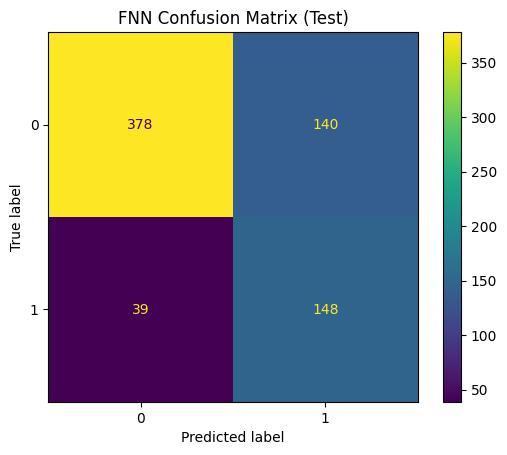

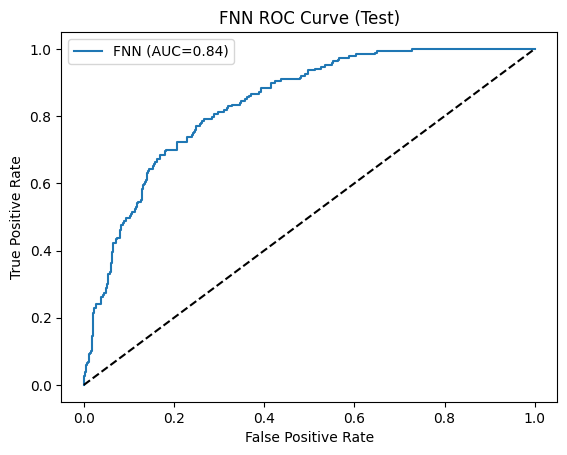

In [16]:
# Feed Forward Neural Network (FNN) with Optuna hyperparameter tuning (F1-based)
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True

def create_fnn_model(trial):
    n_units = trial.suggest_int('n_units', 16, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential([
        layers.Input(shape=(X_train_proc.shape[1],)),
        layers.Dense(n_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_fnn(trial):
    model = create_fnn_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_fnn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_fnn.optimize(objective_fnn, n_trials=50, show_progress_bar=True)

best_params_fnn = study_fnn.best_params
print('Best FNN hyperparameters:', best_params_fnn)
best_fnn = create_fnn_model(optuna.trial.FixedTrial(best_params_fnn))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_fnn.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_fnn['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final FNN early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_fnn.set_weights(f1_callback_final.best_weights)

pred_test_fnn = best_fnn.predict(X_test_proc).ravel()
pred_test_label_fnn = (pred_test_fnn > 0.5).astype(int)
cm_fnn = confusion_matrix(y_test, pred_test_label_fnn)
roc_auc_fnn = roc_auc_score(y_test, pred_test_fnn)
f1_fnn = f1_score(y_test, pred_test_label_fnn)
precision_fnn = precision_score(y_test, pred_test_label_fnn)
recall_fnn = recall_score(y_test, pred_test_label_fnn)
specificity_fnn = cm_fnn[0,0] / (cm_fnn[0,0] + cm_fnn[0,1]) if (cm_fnn[0,0] + cm_fnn[0,1]) > 0 else 0
accuracy_fnn = (cm_fnn[0,0] + cm_fnn[1,1]) / cm_fnn.sum()
print('FNN Test Results:')
print(f'Accuracy: {accuracy_fnn:.4f}')
print(f'F1 Score: {f1_fnn:.4f}')
print(f'Precision: {precision_fnn:.4f}')
print(f'Recall (Sensitivity): {recall_fnn:.4f}')
print(f'Specificity: {specificity_fnn:.4f}')
print(f'AUC: {roc_auc_fnn:.4f}')
ConfusionMatrixDisplay(cm_fnn).plot()
plt.title('FNN Confusion Matrix (Test)')
plt.show()
fpr_fnn, tpr_fnn, _ = roc_curve(y_test, pred_test_fnn)
plt.figure()
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN (AUC={roc_auc_fnn:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FNN ROC Curve (Test)')
plt.legend()
plt.show()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[I 2025-11-21 19:15:37,165] A new study created in memory with name: no-name-b25db498-b41b-47d4-b253-25583feec282
Best trial: 0. Best value: 0.636175:   2%|▏         | 1/50 [00:32<26:51, 32.88s/it]

Early stopping at epoch 11; best val F1=0.6362
Trial early stopped at epoch 11 (best val F1=0.6362)
[I 2025-11-21 19:16:10,047] Trial 0 finished with value: 0.6361746361746362 and parameters: {'n_layers': 3, 'n_units': 124, 'lr': 0.0029106359131330704, 'dropout': 0.2993292420985183, 'batch_size': 47}. Best is trial 0 with value: 0.6361746361746362.


Best trial: 1. Best value: 0.647826:   4%|▍         | 2/50 [01:07<27:19, 34.16s/it]

Early stopping at epoch 26; best val F1=0.6478
Trial early stopped at epoch 26 (best val F1=0.6478)
[I 2025-11-21 19:16:45,107] Trial 1 finished with value: 0.6478260869565218 and parameters: {'n_layers': 2, 'n_units': 37, 'lr': 0.005399484409787433, 'dropout': 0.3005575058716044, 'batch_size': 100}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:   6%|▌         | 3/50 [01:24<20:30, 26.18s/it]

Early stopping at epoch 6; best val F1=0.6372
Trial early stopped at epoch 6 (best val F1=0.6372)
[I 2025-11-21 19:17:01,793] Trial 2 finished with value: 0.6371681415929203 and parameters: {'n_layers': 2, 'n_units': 126, 'lr': 0.004622589001020831, 'dropout': 0.10616955533913808, 'batch_size': 49}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:   8%|▊         | 4/50 [01:50<19:59, 26.07s/it]

Early stopping at epoch 12; best val F1=0.6390
Trial early stopped at epoch 12 (best val F1=0.6390)
[I 2025-11-21 19:17:27,701] Trial 3 finished with value: 0.6390041493775933 and parameters: {'n_layers': 2, 'n_units': 61, 'lr': 0.0011207606211860567, 'dropout': 0.21597250932105788, 'batch_size': 60}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  10%|█         | 5/50 [02:06<16:54, 22.55s/it]

Early stopping at epoch 6; best val F1=0.6347
Trial early stopped at epoch 6 (best val F1=0.6347)
[I 2025-11-21 19:17:43,989] Trial 4 finished with value: 0.6346555323590815 and parameters: {'n_layers': 3, 'n_units': 45, 'lr': 0.0003839629299804173, 'dropout': 0.18318092164684585, 'batch_size': 76}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  12%|█▏        | 6/50 [03:21<29:39, 40.44s/it]

Early stopping at epoch 17; best val F1=0.6448
Trial early stopped at epoch 17 (best val F1=0.6448)
[I 2025-11-21 19:18:59,154] Trial 5 finished with value: 0.6447638603696099 and parameters: {'n_layers': 4, 'n_units': 51, 'lr': 0.0010677482709481358, 'dropout': 0.29620728443102123, 'batch_size': 36}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  14%|█▍        | 7/50 [04:02<28:56, 40.37s/it]

[I 2025-11-21 19:19:39,396] Trial 6 finished with value: 0.6363636363636364 and parameters: {'n_layers': 3, 'n_units': 48, 'lr': 0.00013492834268013249, 'dropout': 0.4744427686266666, 'batch_size': 125}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  16%|█▌        | 8/50 [04:30<25:38, 36.63s/it]

Early stopping at epoch 11; best val F1=0.6288
Trial early stopped at epoch 11 (best val F1=0.6288)
[I 2025-11-21 19:20:08,003] Trial 7 finished with value: 0.6288032454361054 and parameters: {'n_layers': 4, 'n_units': 61, 'lr': 0.0001567993391672301, 'dropout': 0.34211651325607845, 'batch_size': 74}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  18%|█▊        | 9/50 [04:56<22:40, 33.18s/it]

Early stopping at epoch 11; best val F1=0.6354
Trial early stopped at epoch 11 (best val F1=0.6354)
[I 2025-11-21 19:20:33,604] Trial 8 finished with value: 0.6354378818737271 and parameters: {'n_layers': 2, 'n_units': 80, 'lr': 0.00011715937392307068, 'dropout': 0.45466020103939103, 'batch_size': 57}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  20%|██        | 10/50 [05:37<23:48, 35.71s/it]

Early stopping at epoch 12; best val F1=0.6375
Trial early stopped at epoch 12 (best val F1=0.6375)
[I 2025-11-21 19:21:14,994] Trial 9 finished with value: 0.6375 and parameters: {'n_layers': 3, 'n_units': 62, 'lr': 0.001096821720752952, 'dropout': 0.2733551396716398, 'batch_size': 49}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  22%|██▏       | 11/50 [05:51<18:51, 29.01s/it]

Early stopping at epoch 8; best val F1=0.6389
Trial early stopped at epoch 8 (best val F1=0.6389)
[I 2025-11-21 19:21:28,808] Trial 10 finished with value: 0.6389496717724289 and parameters: {'n_layers': 2, 'n_units': 32, 'lr': 0.008691089486124988, 'dropout': 0.0089809378074098, 'batch_size': 112}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  24%|██▍       | 12/50 [06:19<18:09, 28.68s/it]

Early stopping at epoch 13; best val F1=0.6367
Trial early stopped at epoch 13 (best val F1=0.6367)
[I 2025-11-21 19:21:56,718] Trial 11 finished with value: 0.636734693877551 and parameters: {'n_layers': 4, 'n_units': 32, 'lr': 0.002085471360853434, 'dropout': 0.3739084974067327, 'batch_size': 101}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  26%|██▌       | 13/50 [07:11<21:57, 35.61s/it]

Early stopping at epoch 10; best val F1=0.6341
Trial early stopped at epoch 10 (best val F1=0.6341)
[I 2025-11-21 19:22:48,286] Trial 12 finished with value: 0.6341463414634146 and parameters: {'n_layers': 4, 'n_units': 91, 'lr': 0.0004569757357815038, 'dropout': 0.3806736357247846, 'batch_size': 34}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  28%|██▊       | 14/50 [07:44<20:54, 34.84s/it]

Early stopping at epoch 14; best val F1=0.6010
Trial early stopped at epoch 14 (best val F1=0.6010)
[I 2025-11-21 19:23:21,334] Trial 13 finished with value: 0.6009852216748769 and parameters: {'n_layers': 4, 'n_units': 80, 'lr': 0.009729045865520656, 'dropout': 0.13766299003917637, 'batch_size': 94}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  30%|███       | 15/50 [08:23<21:06, 36.18s/it]

Early stopping at epoch 21; best val F1=0.6403
Trial early stopped at epoch 21 (best val F1=0.6403)
[I 2025-11-21 19:24:00,612] Trial 14 finished with value: 0.6403326403326404 and parameters: {'n_layers': 3, 'n_units': 52, 'lr': 0.0006171267191302158, 'dropout': 0.28379580681439237, 'batch_size': 92}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  32%|███▏      | 16/50 [09:02<21:03, 37.16s/it]

Early stopping at epoch 20; best val F1=0.6449
Trial early stopped at epoch 20 (best val F1=0.6449)
[I 2025-11-21 19:24:40,074] Trial 15 finished with value: 0.6448979591836734 and parameters: {'n_layers': 4, 'n_units': 95, 'lr': 0.0022270414378132127, 'dropout': 0.41402589218691876, 'batch_size': 107}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  34%|███▍      | 17/50 [09:22<17:30, 31.85s/it]

Early stopping at epoch 10; best val F1=0.6417
Trial early stopped at epoch 10 (best val F1=0.6417)
[I 2025-11-21 19:24:59,551] Trial 16 finished with value: 0.6416666666666667 and parameters: {'n_layers': 2, 'n_units': 105, 'lr': 0.004373273933564994, 'dropout': 0.43010862710809544, 'batch_size': 115}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  36%|███▌      | 18/50 [09:53<16:48, 31.53s/it]

Early stopping at epoch 18; best val F1=0.6364
Trial early stopped at epoch 18 (best val F1=0.6364)
[I 2025-11-21 19:25:30,345] Trial 17 finished with value: 0.6363636363636364 and parameters: {'n_layers': 3, 'n_units': 102, 'lr': 0.0019379580932659451, 'dropout': 0.4061843195542296, 'batch_size': 107}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  38%|███▊      | 19/50 [10:32<17:33, 33.98s/it]

Early stopping at epoch 18; best val F1=0.6358
Trial early stopped at epoch 18 (best val F1=0.6358)
[I 2025-11-21 19:26:10,016] Trial 18 finished with value: 0.6358381502890174 and parameters: {'n_layers': 4, 'n_units': 77, 'lr': 0.005372063299447951, 'dropout': 0.4951342441866507, 'batch_size': 92}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  40%|████      | 20/50 [10:46<14:00, 28.01s/it]

Early stopping at epoch 7; best val F1=0.6212
Trial early stopped at epoch 7 (best val F1=0.6212)
[I 2025-11-21 19:26:24,115] Trial 19 finished with value: 0.6212424849699398 and parameters: {'n_layers': 2, 'n_units': 113, 'lr': 0.002600044586389357, 'dropout': 0.33661746562240874, 'batch_size': 123}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  42%|████▏     | 21/50 [11:20<14:19, 29.64s/it]

Early stopping at epoch 16; best val F1=0.6344
Trial early stopped at epoch 16 (best val F1=0.6344)
[I 2025-11-21 19:26:57,575] Trial 20 finished with value: 0.6343612334801763 and parameters: {'n_layers': 3, 'n_units': 92, 'lr': 0.0016539406162826053, 'dropout': 0.3478603112702862, 'batch_size': 88}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  44%|████▍     | 22/50 [11:41<12:37, 27.04s/it]

Early stopping at epoch 7; best val F1=0.6474
Trial early stopped at epoch 7 (best val F1=0.6474)
[I 2025-11-21 19:27:18,554] Trial 21 finished with value: 0.6474226804123712 and parameters: {'n_layers': 4, 'n_units': 39, 'lr': 0.000785974728314471, 'dropout': 0.23891287001945344, 'batch_size': 102}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  46%|████▌     | 23/50 [12:15<13:03, 29.02s/it]

Early stopping at epoch 15; best val F1=0.6364
Trial early stopped at epoch 15 (best val F1=0.6364)
[I 2025-11-21 19:27:52,195] Trial 22 finished with value: 0.6363636363636364 and parameters: {'n_layers': 4, 'n_units': 41, 'lr': 0.0035616379657549984, 'dropout': 0.2352081784054213, 'batch_size': 104}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  48%|████▊     | 24/50 [12:42<12:24, 28.64s/it]

Early stopping at epoch 8; best val F1=0.6233
Trial early stopped at epoch 8 (best val F1=0.6233)
[I 2025-11-21 19:28:19,934] Trial 23 finished with value: 0.6233269598470363 and parameters: {'n_layers': 4, 'n_units': 69, 'lr': 0.000660918437630159, 'dropout': 0.18867207567360106, 'batch_size': 84}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  50%|█████     | 25/50 [13:22<13:17, 31.90s/it]

Early stopping at epoch 21; best val F1=0.6454
Trial early stopped at epoch 21 (best val F1=0.6454)
[I 2025-11-21 19:28:59,431] Trial 24 finished with value: 0.6454352441613588 and parameters: {'n_layers': 4, 'n_units': 38, 'lr': 0.000256557034746652, 'dropout': 0.132035183231185, 'batch_size': 115}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  52%|█████▏    | 26/50 [14:07<14:21, 35.91s/it]

Early stopping at epoch 29; best val F1=0.6448
Trial early stopped at epoch 29 (best val F1=0.6448)
[I 2025-11-21 19:29:44,706] Trial 25 finished with value: 0.6447638603696099 and parameters: {'n_layers': 3, 'n_units': 42, 'lr': 0.00021924139515389331, 'dropout': 0.07590135690609673, 'batch_size': 116}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 1. Best value: 0.647826:  54%|█████▍    | 27/50 [14:32<12:27, 32.52s/it]

Early stopping at epoch 9; best val F1=0.6293
Trial early stopped at epoch 9 (best val F1=0.6293)
[I 2025-11-21 19:30:09,310] Trial 26 finished with value: 0.6292585170340681 and parameters: {'n_layers': 4, 'n_units': 38, 'lr': 0.00028776826943199173, 'dropout': 0.16276821220524595, 'batch_size': 99}. Best is trial 1 with value: 0.6478260869565218.


Best trial: 27. Best value: 0.651546:  56%|█████▌    | 28/50 [14:53<10:43, 29.27s/it]

Early stopping at epoch 11; best val F1=0.6515
Trial early stopped at epoch 11 (best val F1=0.6515)
[I 2025-11-21 19:30:31,009] Trial 27 finished with value: 0.6515463917525773 and parameters: {'n_layers': 3, 'n_units': 37, 'lr': 0.0002298077256460669, 'dropout': 0.06084495243681434, 'batch_size': 120}. Best is trial 27 with value: 0.6515463917525773.


Best trial: 27. Best value: 0.651546:  58%|█████▊    | 29/50 [15:10<08:52, 25.38s/it]

Early stopping at epoch 9; best val F1=0.6318
Trial early stopped at epoch 9 (best val F1=0.6318)
[I 2025-11-21 19:30:47,293] Trial 28 finished with value: 0.6317991631799164 and parameters: {'n_layers': 2, 'n_units': 54, 'lr': 0.0006188349001000425, 'dropout': 0.0019140395106325009, 'batch_size': 128}. Best is trial 27 with value: 0.6515463917525773.


Best trial: 27. Best value: 0.651546:  60%|██████    | 30/50 [15:49<09:54, 29.70s/it]

Early stopping at epoch 24; best val F1=0.6473
Trial early stopped at epoch 24 (best val F1=0.6473)
[I 2025-11-21 19:31:27,097] Trial 29 finished with value: 0.6473029045643154 and parameters: {'n_layers': 3, 'n_units': 57, 'lr': 0.0001883915009494775, 'dropout': 0.05854117658759614, 'batch_size': 120}. Best is trial 27 with value: 0.6515463917525773.


Best trial: 27. Best value: 0.651546:  62%|██████▏   | 31/50 [16:32<10:40, 33.70s/it]

Early stopping at epoch 18; best val F1=0.6412
Trial early stopped at epoch 18 (best val F1=0.6412)
[I 2025-11-21 19:32:10,137] Trial 30 finished with value: 0.6411889596602972 and parameters: {'n_layers': 2, 'n_units': 72, 'lr': 0.0014255593664974351, 'dropout': 0.26202296862921937, 'batch_size': 68}. Best is trial 27 with value: 0.6515463917525773.


Best trial: 27. Best value: 0.651546:  64%|██████▍   | 32/50 [17:16<10:57, 36.51s/it]

Early stopping at epoch 24; best val F1=0.6475
Trial early stopped at epoch 24 (best val F1=0.6475)
[I 2025-11-21 19:32:53,196] Trial 31 finished with value: 0.6475409836065574 and parameters: {'n_layers': 3, 'n_units': 33, 'lr': 0.0001757882476436998, 'dropout': 0.052012315677032524, 'batch_size': 121}. Best is trial 27 with value: 0.6515463917525773.


Best trial: 32. Best value: 0.652977:  66%|██████▌   | 33/50 [17:52<10:18, 36.39s/it]

Early stopping at epoch 15; best val F1=0.6530
Trial early stopped at epoch 15 (best val F1=0.6530)
[I 2025-11-21 19:33:29,287] Trial 32 finished with value: 0.6529774127310062 and parameters: {'n_layers': 3, 'n_units': 36, 'lr': 0.000361457494118731, 'dropout': 0.05113551662973396, 'batch_size': 108}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  68%|██████▊   | 34/50 [18:24<09:24, 35.27s/it]

Early stopping at epoch 16; best val F1=0.6337
Trial early stopped at epoch 16 (best val F1=0.6337)
[I 2025-11-21 19:34:01,962] Trial 33 finished with value: 0.6337448559670782 and parameters: {'n_layers': 3, 'n_units': 33, 'lr': 0.0003598048821496067, 'dropout': 0.04837297680508282, 'batch_size': 110}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  70%|███████   | 35/50 [19:03<09:06, 36.42s/it]

Early stopping at epoch 22; best val F1=0.6515
Trial early stopped at epoch 22 (best val F1=0.6515)
[I 2025-11-21 19:34:41,052] Trial 34 finished with value: 0.6515463917525773 and parameters: {'n_layers': 3, 'n_units': 48, 'lr': 0.00017124525389698286, 'dropout': 0.11264150090594907, 'batch_size': 119}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  72%|███████▏  | 36/50 [19:52<09:22, 40.17s/it]

Early stopping at epoch 28; best val F1=0.6474
Trial early stopped at epoch 28 (best val F1=0.6474)
[I 2025-11-21 19:35:29,975] Trial 35 finished with value: 0.6474226804123712 and parameters: {'n_layers': 3, 'n_units': 46, 'lr': 0.0001094032110611736, 'dropout': 0.10138997977493973, 'batch_size': 118}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  74%|███████▍  | 37/50 [20:20<07:53, 36.39s/it]

Early stopping at epoch 13; best val F1=0.6309
Trial early stopped at epoch 13 (best val F1=0.6309)
[I 2025-11-21 19:35:57,538] Trial 36 finished with value: 0.6309278350515464 and parameters: {'n_layers': 2, 'n_units': 47, 'lr': 0.0004419670629099569, 'dropout': 0.08635675959419234, 'batch_size': 97}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  76%|███████▌  | 38/50 [20:51<06:56, 34.73s/it]

Early stopping at epoch 13; best val F1=0.6360
Trial early stopped at epoch 13 (best val F1=0.6360)
[I 2025-11-21 19:36:28,411] Trial 37 finished with value: 0.6359832635983264 and parameters: {'n_layers': 3, 'n_units': 42, 'lr': 0.0003105357129308246, 'dropout': 0.02857153388992545, 'batch_size': 111}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  78%|███████▊  | 39/50 [21:30<06:36, 36.05s/it]

Early stopping at epoch 21; best val F1=0.6448
Trial early stopped at epoch 21 (best val F1=0.6448)
[I 2025-11-21 19:37:07,527] Trial 38 finished with value: 0.6447638603696099 and parameters: {'n_layers': 3, 'n_units': 60, 'lr': 0.00014230749875839235, 'dropout': 0.13943815865566117, 'batch_size': 125}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  80%|████████  | 40/50 [22:27<07:03, 42.38s/it]

Early stopping at epoch 24; best val F1=0.6515
Trial early stopped at epoch 24 (best val F1=0.6515)
[I 2025-11-21 19:38:04,696] Trial 39 finished with value: 0.6515463917525773 and parameters: {'n_layers': 3, 'n_units': 49, 'lr': 0.00022163946976760693, 'dropout': 0.207319893460215, 'batch_size': 80}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  82%|████████▏ | 41/50 [23:05<06:09, 41.06s/it]

Early stopping at epoch 13; best val F1=0.6371
Trial early stopped at epoch 13 (best val F1=0.6371)
[I 2025-11-21 19:38:42,673] Trial 40 finished with value: 0.6371308016877637 and parameters: {'n_layers': 3, 'n_units': 49, 'lr': 0.00022789330680207613, 'dropout': 0.1061567449140892, 'batch_size': 76}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  84%|████████▍ | 42/50 [23:51<05:39, 42.44s/it]

Early stopping at epoch 17; best val F1=0.6405
Trial early stopped at epoch 17 (best val F1=0.6405)
[I 2025-11-21 19:39:28,330] Trial 41 finished with value: 0.640495867768595 and parameters: {'n_layers': 3, 'n_units': 67, 'lr': 0.00010023463887508214, 'dropout': 0.21203679374796627, 'batch_size': 79}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  86%|████████▌ | 43/50 [24:29<04:48, 41.18s/it]

Early stopping at epoch 9; best val F1=0.6448
Trial early stopped at epoch 9 (best val F1=0.6448)
[I 2025-11-21 19:40:06,552] Trial 42 finished with value: 0.6447638603696099 and parameters: {'n_layers': 3, 'n_units': 55, 'lr': 0.00018571270776320624, 'dropout': 0.3112271899455038, 'batch_size': 65}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  88%|████████▊ | 44/50 [25:10<04:06, 41.10s/it]

Early stopping at epoch 16; best val F1=0.6488
Trial early stopped at epoch 16 (best val F1=0.6488)
[I 2025-11-21 19:40:47,482] Trial 43 finished with value: 0.6487603305785123 and parameters: {'n_layers': 3, 'n_units': 36, 'lr': 0.0003684148360071426, 'dropout': 0.027925163246699636, 'batch_size': 85}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  90%|█████████ | 45/50 [25:55<03:31, 42.22s/it]

Early stopping at epoch 18; best val F1=0.6420
Trial early stopped at epoch 18 (best val F1=0.6420)
[I 2025-11-21 19:41:32,322] Trial 44 finished with value: 0.6419753086419753 and parameters: {'n_layers': 3, 'n_units': 44, 'lr': 0.00046470466238823663, 'dropout': 0.026455843801402867, 'batch_size': 83}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  92%|█████████▏| 46/50 [26:53<03:07, 46.99s/it]

Early stopping at epoch 22; best val F1=0.6421
Trial early stopped at epoch 22 (best val F1=0.6421)
[I 2025-11-21 19:42:30,427] Trial 45 finished with value: 0.6421267893660532 and parameters: {'n_layers': 3, 'n_units': 36, 'lr': 0.0003373560271389877, 'dropout': 0.08131041651529457, 'batch_size': 72}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  94%|█████████▍| 47/50 [28:16<02:53, 57.79s/it]

Early stopping at epoch 28; best val F1=0.6339
Trial early stopped at epoch 28 (best val F1=0.6339)
[I 2025-11-21 19:43:53,432] Trial 46 finished with value: 0.6339468302658486 and parameters: {'n_layers': 3, 'n_units': 49, 'lr': 0.00013736954261058716, 'dropout': 0.026319584154578426, 'batch_size': 59}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  96%|█████████▌| 48/50 [28:54<01:43, 51.82s/it]

Early stopping at epoch 12; best val F1=0.6358
Trial early stopped at epoch 12 (best val F1=0.6358)
[I 2025-11-21 19:44:31,319] Trial 47 finished with value: 0.635814889336016 and parameters: {'n_layers': 3, 'n_units': 36, 'lr': 0.0002447029203234136, 'dropout': 0.16000849985339474, 'batch_size': 87}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977:  98%|█████████▊| 49/50 [29:32<00:47, 47.79s/it]

Early stopping at epoch 8; best val F1=0.6273
Trial early stopped at epoch 8 (best val F1=0.6273)
[I 2025-11-21 19:45:09,717] Trial 48 finished with value: 0.6272912423625254 and parameters: {'n_layers': 3, 'n_units': 45, 'lr': 0.00042523818966519814, 'dropout': 0.11713212570773615, 'batch_size': 53}. Best is trial 32 with value: 0.6529774127310062.


Best trial: 32. Best value: 0.652977: 100%|██████████| 50/50 [30:14<00:00, 36.30s/it]

Early stopping at epoch 8; best val F1=0.6461
Trial early stopped at epoch 8 (best val F1=0.6461)
[I 2025-11-21 19:45:51,983] Trial 49 finished with value: 0.6460905349794238 and parameters: {'n_layers': 3, 'n_units': 63, 'lr': 0.0005455903912706116, 'dropout': 0.061157713611045605, 'batch_size': 45}. Best is trial 32 with value: 0.6529774127310062.
Best MLP hyperparameters: {'n_layers': 3, 'n_units': 36, 'lr': 0.000361457494118731, 'dropout': 0.05113551662973396, 'batch_size': 108}


Early stopping at epoch 14; best val F1=0.6501
Final MLP early stopped at epoch 14 (best val F1=0.6501)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MLP Test Results:
Accuracy: 0.7404
F1 Score: 0.6164
Precision: 0.5069
Recall (Sensitivity): 0.7861
Specificity: 0.7239
AUC: 0.8376


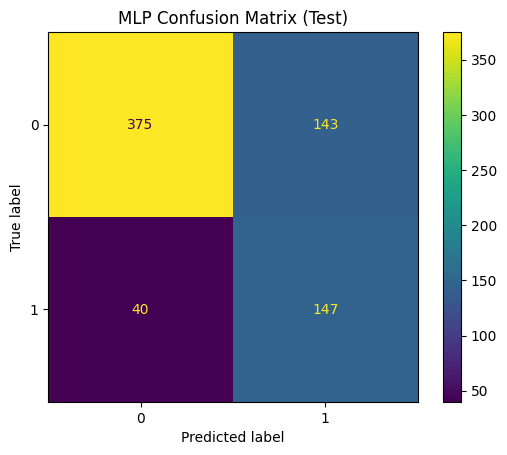

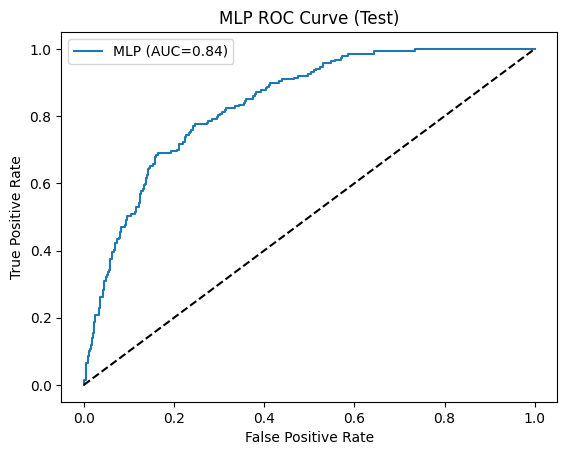

In [9]:
# Multi-Layer Perceptron (MLP) with Optuna hyperparameter tuning (F1-based)
# F1EarlyStopping already defined above; class weights removed
%pip install tensorflow-macos tensorflow-metal
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Deterministic TensorFlow config
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# Class weights removed (data already oversampled to balance classes)

class F1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.patience = patience
        self.best_f1 = -1
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = None
    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.X_val, verbose=0).ravel() > 0.5).astype(int)
        current_f1 = f1_score(self.y_val, preds)
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch + 1
                print(f'Early stopping at epoch {self.stopped_epoch}; best val F1={self.best_f1:.4f}')
                self.model.stop_training = True
            
def create_mlp_model(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    n_units = trial.suggest_int('n_units', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train_proc.shape[1],)))
    for _ in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def objective_mlp(trial):
    model = create_mlp_model(trial)
    f1_callback = F1EarlyStopping(X_val_proc, y_val, patience=5)
    model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=30,
        batch_size=trial.suggest_int('batch_size', 32, 128),
        verbose=0,
        callbacks=[f1_callback]
    )
    if f1_callback.stopped_epoch is not None:
        print(f'Trial early stopped at epoch {f1_callback.stopped_epoch} (best val F1={f1_callback.best_f1:.4f})')
    if f1_callback.best_weights is not None:
        model.set_weights(f1_callback.best_weights)
    return f1_callback.best_f1

study_mlp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True)

best_params_mlp = study_mlp.best_params
print('Best MLP hyperparameters:', best_params_mlp)
best_mlp = create_mlp_model(optuna.trial.FixedTrial(best_params_mlp))
f1_callback_final = F1EarlyStopping(X_val_proc, y_val, patience=5)
best_mlp.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    epochs=30,
    batch_size=best_params_mlp['batch_size'],
    verbose=0,
    callbacks=[f1_callback_final]
)
if f1_callback_final.stopped_epoch is not None:
    print(f'Final MLP early stopped at epoch {f1_callback_final.stopped_epoch} (best val F1={f1_callback_final.best_f1:.4f})')
if f1_callback_final.best_weights is not None:
    best_mlp.set_weights(f1_callback_final.best_weights)

pred_test_mlp = best_mlp.predict(X_test_proc).ravel()
pred_test_label_mlp = (pred_test_mlp > 0.5).astype(int)
cm_mlp = confusion_matrix(y_test, pred_test_label_mlp)
roc_auc_mlp = roc_auc_score(y_test, pred_test_mlp)
f1_mlp = f1_score(y_test, pred_test_label_mlp)
precision_mlp = precision_score(y_test, pred_test_label_mlp)
recall_mlp = recall_score(y_test, pred_test_label_mlp)
specificity_mlp = cm_mlp[0,0] / (cm_mlp[0,0] + cm_mlp[0,1]) if (cm_mlp[0,0] + cm_mlp[0,1]) > 0 else 0
accuracy_mlp = (cm_mlp[0,0] + cm_mlp[1,1]) / cm_mlp.sum()
print('MLP Test Results:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall (Sensitivity): {recall_mlp:.4f}')
print(f'Specificity: {specificity_mlp:.4f}')
print(f'AUC: {roc_auc_mlp:.4f}')
ConfusionMatrixDisplay(cm_mlp).plot()
plt.title('MLP Confusion Matrix (Test)')
plt.show()
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, pred_test_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve (Test)')
plt.legend()
plt.show()